# Importing Required libraries

In [0]:
#Required Libraries

import nltk
import pandas as pd
import numpy as np 
import re
from gensim.models import Word2Vec
from io import StringIO
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

# Importing Required Packages

In [0]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
import nltk
nltk.download('averaged_perceptron_tagger')
  

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading and Preprocessing   
1.Removed the words other than A-Z and a-z and space

---


2.Tokenize the words

---


3.Convert the tokenized words into a list 








In [0]:

# importing the stop words
stop_words = set(nltk.corpus.stopwords.words('english')) 

lemmatizer = nltk.stem.WordNetLemmatizer()

dt = []

# importing the sample dataset from Emotion_Phrases.csv
an = open('/content/drive/My Drive/Dataset/ANGER_Phrases.txt', 'r')
anger = an.readlines()
an.close()
for i in anger:
    dt.append([i, 'anger'])

fe = open('/content/drive/My Drive/Dataset/FEAR_Phrases.txt', 'r')
fear = fe.readlines()
fe.close()
for i in fear:
    dt.append([i, 'fear'])

jo = open('/content/drive/My Drive/Dataset/JOY_Phrases.txt', 'r')
joy = jo.readlines()
jo.close()
for i in joy:
    dt.append([i, 'joy'])

lo = open('/content/drive/My Drive/Dataset/LOVE_Phrases.txt', 'r')
love = lo.readlines()
lo.close()
for i in love:
    dt.append([i, 'love'])

sa = open('/content/drive/My Drive/Dataset/SADNESS_Phrases.txt', 'r')
sad = sa.readlines()
sa.close()
for i in sad:
    dt.append([i, 'sad'])

su = open('/content/drive/My Drive/Dataset/SURPRISE_Phrases.txt', 'r')
surprise = su.readlines()
su.close()
for i in surprise:
    dt.append([i, 'surprise'])

print(len(dt))

data = pd.DataFrame(dt)

# adding the coloumns names
data.columns = ['text', 'emotions']

# getting the informations of data
data.info()


# converting the emotions to the ids
data['emo_id'] = data['emotions'].factorize()[0]

# print(data.head(10))
# print(data['emo_id'])
#data.iloc[np.random.permutation(len(data))]
#data.reindex(np.random.permutation(data.index))

data = data.sample(frac=1)

#print(data)



# dropped the duplicates and sorted it
emo_id_df = data[['emotions', 'emo_id']].drop_duplicates().sort_values('emo_id')

# converted it into a dictionary 
emo_to_id = dict(emo_id_df.values)

# representing the dataset with a plot


# converted the data into the dictionary
data_dict = data.to_dict()

sw_rem = []
txt = []
tagged = []

# preprocessed the database:
#       *   Removed the words other than A-Z and a-z and space
#       *   Tokenize the words
#       *   Convert the tokenized words into a list
tagged = []
print(list(data_dict['text'].values())[:5])
for k in range(len(list(data_dict['text'])[:12000])):
    data_dict['text'][k] = re.sub('([^A-Za-z ])', '', data_dict['text'][k])
    txt.append(nltk.tokenize.word_tokenize(data_dict['text'][k]))
    tagged.append(nltk.pos_tag(txt[k]))
    for j in range(len(txt[k])):
        if (txt[k][j] not in stop_words) and (tagged[k][j][1] not in ['CC', 'CD', 'IN', 'LS', 'TO']): 
           sw_rem.append(lemmatizer.lemmatize(txt[k][j]))
    data_dict['text'][k] = " ".join(sw_rem)
    sw_rem = [] 
print(list(data_dict['text'].values())[:5])
data = pd.DataFrame.from_dict(data_dict)
#print(data)


487769
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487769 entries, 0 to 487768
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      487769 non-null  object
 1   emotions  487769 non-null  object
dtypes: object(2)
memory usage: 7.4+ MB
['i feel is not quite discontent more like a dull anxiety\n', 'i suggest you will feel electricity going through your body when you get to the word terrific\n', 'i feel no less excited than the millions who wait religiously every four years for the extreme extravaganza\n', "i've been feeling a bit sentimental this week possibly due to the fact that i graduate from college in 8\n", 'i could feel myself becoming more and more agitated which was almost a new sensation\n']
['i feel is not quite discontent more like a dull anxiety\n', 'i suggest you will feel electricity going through your body when you get to the word terrific\n', 'i feel no less excited than the millions who wait r

## Representation of dataset with respective Emotions

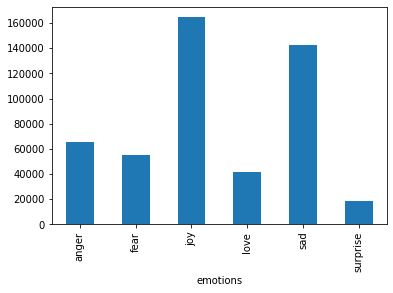

In [0]:
fig = plt.figure()
data.groupby('emotions').text.count().plot.bar(ylim=0)
plt.show()

# Extracting features


1.   CountVectorizer:   We segment each text file into words. count no. of times each word occurs in each document(tweet) and finally assign each word an integer id. Each unique word in our dictionary will correspond to a feature
2.   TF:   CountVectorizer will give more weightage to longer documents than shorter documents. To avoid this, we can use frequency (TF - Term Frequencies) i.e. #count(word) / #Total words, in each document.
3. TF-IDF:    Finally, we can even reduce the weightage of more common words like (the, is, an etc.) which occurs in all document. This is called as TF-IDF i.e Term Frequency times inverse document frequency.





In [0]:

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(data.text[:12000])
#print(X_train_counts)
#print(X_train_counts.shape)


tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
from scipy import sparse
X_train_tfidf = sparse.lil_matrix(sparse.csr_matrix(X_train_tfidf))
#print(X_train_tfidf)
print(X_train_tfidf.shape)

(12000, 300)


# Converting Sparse Matrix to Dense Matrix

In [0]:
labels = data.emo_id
#print(X_train_tfidf)
#print(features.get_shape())
features_d = X_train_tfidf.toarray()
#print(features_d)
rows = len(features_d)
columns = len(features_d[0])
print(rows)
print(columns)
############
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X_train_tfidf[:12000], labels[:12000], data.index[:12000], test_size=0.33, random_state=0)

12000
300


# PCA Analysis

## 1. Normalize Function

In [0]:
def normalize(X):
 mu = np.mean(X, axis=0)
 std = np.std(X, axis=0)
 a = np.subtract(X,mu)
 new_std = np.where(std>0,std,1)
 Xbar = np.divide(a,new_std)
 # std_filled = std.copy()
 # std_filled[std==0] = 1.
 return Xbar, mu, std


## 2. Eig Function
  It will compute :  

1.   Eigen Values
2.   Eigen Vector




In [0]:
def eig(S):
 eigvals, eigvecs = np.linalg.eig(S)
 idx = eigvals.argsort()[::-1]
 eigvals = eigvals[idx]
 eigvecs = eigvecs[:,idx]
 return (eigvals, eigvecs)

## 3. Projection_Matrix Function
Computes the projection matrix onto the space spanned by `B`

In [0]:
def projection_matrix(B):
 P = np.matmul(B,B.T)
 #return np.eye(B.shape[0]) # <-- EDIT THIS to compute the projection matrix
 return P

# 4. PCA Function
*   Input
      1.   X: ndarray of size (N, D), where D is the dimension of the data, and N is the number of datapoints
      2.   num_components: the number of principal components to use.
*   Returns
      1.   X_reconstruct: ndarray of the reconstruction
  of X from the first `num_components` principal components.
      2.   sum_value: sum of eigen values from the first `num_components` principal components.







In [0]:
def PCA(X, num_components):
 Xbar, mu, std = normalize(X)
 covariance = np.dot(Xbar.T,Xbar)
 S = covariance
 eigvals, eigvecs = eig(S)
 # eigen_trans = eigvecs.T
 # B = np.stack(eigen_trans[:,:num_components])
 sum_value = sum(eigvals[:num_components])
 B = np.stack(eigvecs[:,:num_components])
 P = np.matmul(B,B.T)
 X_reconstruct = np.matmul(P,X.T)
 X_reconstruct = X_reconstruct.T
 return X_reconstruct, sum_value

## 5. Normalizing Input Matrix
Normalization is necessary to make every variable in proportion with each other

In [0]:
NUM_DATAPOINTS = 12000
data1 = (features_d [:NUM_DATAPOINTS]) / 255.
#print(data1)
Xbar, mu, std = normalize(data1)
print(Xbar.shape)
print(mu.shape)
print(std.shape)
#print(np.trace(Xbar))

(12000, 300)
(300,)
(300,)


## 6. Computing Covariance Matrix

In [0]:
covariance = np.matmul(Xbar.T,Xbar)
print(covariance.shape)
print(np.trace(covariance))
S = covariance
eigvals, eigvecs = eig(S)
print(eigvals[:20])
print(eigvecs)
print(eigvecs.shape[0])

num_components = 150

(300, 300)
3600000.00000004
[120000.26074068+0.j 108524.87731267+0.j  60281.28187458+0.j
  38764.42737301+0.j  36003.00025003+0.j  35997.54296287+0.j
  30773.44589669+0.j  28845.34683143+0.j  28380.92021833+0.j
  27452.28917935+0.j  25533.72507855+0.j  25062.73888633+0.j
  24861.96993826+0.j  24009.13868497+0.j  24002.00016669+0.j
  24002.00016669+0.j  24002.00016668+0.j  24002.00016668+0.j
  24002.00016668+0.j  24002.00016668+0.j]
[[ 5.75424425e-05+0.j  1.83702723e-04+0.j  1.44439640e-04+0.j ...
  -2.56798338e-18+0.j -1.82516022e-16+0.j  2.55865755e-16+0.j]
 [ 5.55247469e-05+0.j  1.77825855e-04+0.j  1.51752223e-04+0.j ...
  -1.37434383e-16+0.j  2.27079139e-16+0.j -5.37468572e-16+0.j]
 [ 3.40494974e-05+0.j  1.09624443e-04+0.j  1.00451425e-04+0.j ...
   1.02441859e-16+0.j -2.39147072e-16+0.j  5.15789278e-16+0.j]
 ...
 [ 4.91754898e-05+0.j  1.56605261e-04+0.j  1.21133451e-04+0.j ...
  -3.12639422e-17+0.j  3.77161396e-18+0.j  3.19814786e-18+0.j]
 [ 2.85194170e-05+0.j  9.08959043e-05+0.j  

## 7. Computing Projection Matrix

In [0]:
B = np.stack(eigvecs[:,:num_components])   
print('Shape of matrix B: ', B.shape)
print('Trace of matrix B: ', np.trace(B))  

P = projection_matrix(B)  # finding projection matrix P
print('Shape of Projection matrix : ', P.shape)

X_reconstruct ,sum_value = PCA(Xbar, num_components)            # finding reconstructed X by selecting num_components principal components
print('Shape of X_reconstruct matrix : ', X_reconstruct.shape)  # printing shape of X_reconstruct matrix
print('Shape of normalized X matrix : ', Xbar.shape)            # printing shape of normalized X matrix

print()
print('X reconstruced : \n', X_reconstruct)

Shape of matrix B:  (300, 150)
Trace of matrix B:  (-0.0026528500836401347+0j)
Shape of Projection matrix :  (300, 300)
Shape of X_reconstruct matrix :  (12000, 300)
Shape of normalized X matrix :  (12000, 300)

X reconstruced : 
 [[-0.01566726+0.j -0.01737241+0.j -0.01447658+0.j ... -0.00070694+0.j
   0.00570329+0.j  0.00570329+0.j]
 [-0.01566726+0.j -0.01737241+0.j -0.01447658+0.j ... -0.00070694+0.j
   0.00570329+0.j  0.00570329+0.j]
 [-0.01566726+0.j -0.01737241+0.j -0.01447658+0.j ... -0.00070694+0.j
   0.00570329+0.j  0.00570329+0.j]
 ...
 [-0.01566726+0.j -0.01737241+0.j -0.01447658+0.j ... -0.00070694+0.j
   0.00570329+0.j  0.00570329+0.j]
 [-0.01566726+0.j -0.01737241+0.j -0.01447658+0.j ... -0.00070694+0.j
   0.00570329+0.j  0.00570329+0.j]
 [-0.01566726+0.j -0.01737241+0.j -0.01447658+0.j ... -0.00070694+0.j
   0.00570329+0.j  0.00570329+0.j]]


## 8. Our PCA function Vs sklearn library

In [0]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=True,with_std=True)
standardized_data = standardized_data.fit_transform(Xbar)

print('Shape of Normalized input matrix computed using library : ' , standardized_data.shape)
print('Shape of Normalized input matrix computed using user functions : ' , Xbar.shape)


sample_data = standardized_data
covar_matrix = np.matmul(sample_data.T, sample_data)

print("Shape of covariance matrix computed using Library = ", covar_matrix.shape)
print("Shape of covariance matrix computed by user functions = ", S.shape)

print('The covariance matrix is : \n' ,covar_matrix)
print('The trace of covariance matrix : ', np.trace(covar_matrix))

Shape of Normalized input matrix computed using library :  (12000, 300)
Shape of Normalized input matrix computed using user functions :  (12000, 300)
Shape of covariance matrix computed using Library =  (300, 300)
Shape of covariance matrix computed by user functions =  (300, 300)
The covariance matrix is : 
 [[ 1.20000000e+04 -3.39021568e+00 -1.95769685e+00 ... -3.32061873e+00
  -1.95769685e+00 -1.95769685e+00]
 [-3.39021568e+00  1.20000000e+04  6.92529103e+03 ... -2.93759318e+00
  -1.73188113e+00 -1.73188113e+00]
 [-1.95769685e+00  6.92529103e+03  1.20000000e+04 ... -1.69632774e+00
  -1.00008334e+00 -1.00008334e+00]
 ...
 [-3.32061873e+00 -2.93759318e+00 -1.69632774e+00 ...  1.20000000e+04
  -1.69632774e+00 -1.69632774e+00]
 [-1.95769685e+00 -1.73188113e+00 -1.00008334e+00 ... -1.69632774e+00
   1.20000000e+04 -1.00008334e+00]
 [-1.95769685e+00 -1.73188113e+00 -1.00008334e+00 ... -1.69632774e+00
  -1.00008334e+00  1.20000000e+04]]
The trace of covariance matrix :  3599999.999999198


## 9. Analysis of number of principal component

In [0]:
for num_component in range(1, 5):
 from sklearn.decomposition import PCA as SKPCA
# We can compute a standard solution given by scikit-learn's implementation of PCA
 pca = SKPCA(n_components=num_component, svd_solver='full')
 sklearn_reconst = pca.inverse_transform(pca.fit_transform(Xbar))
 
 reconst ,sum_value = PCA(Xbar, num_component)
 np.testing.assert_almost_equal(reconst, sklearn_reconst)
 print(np.square(reconst - sklearn_reconst).sum())



(4.550321342891948e-22+0j)
(8.189683479473391e-21+0j)
(8.638116395219288e-21+0j)
(1.7331448128864047e-20+0j)


## 10. Computing loss and variance for every number of principal components

In [0]:
def mse(predict, actual):
 return np.square(predict - actual).sum(axis=1).mean()

loss = []
reconstructions = []
variance_values = []
print(sum_value)
# iterate over different numbers of principal components, and compute the MSE
for num_component in range(1, 140):
    reconst,sum_value = PCA(Xbar, num_component)
    error = mse(reconst, Xbar)
    reconst = reconst*std + mu
    reconstructions.append(reconst)
    # print('n = {:d}, reconstruction_error = {:f}'.format(num_component, error))
    loss.append((num_component, error))
    variance_values.append((num_component, sum_value))
reconstructions = np.asarray(reconstructions)
reconstructions = reconstructions * std + mu # "unnormalize" the reconstructed image
#print(reconstructions)
print(reconstructions.shape)
loss = np.asarray(loss)


(327570.84730092064+0j)
(139, 12000, 300)


In [0]:
import pandas as pd
# create a table showing the number of principal components and MSE
pd.DataFrame(loss).head(100)


,0,1
0,1.000000+0.000000j,289.999978+0.000000j
1,2.000000+0.000000j,280.956238+0.000000j
2,3.000000+0.000000j,275.932798+0.000000j
3,4.000000+0.000000j,272.702429+0.000000j
4,5.000000+0.000000j,269.702179+0.000000j
...,...,...
95,96.000000+0.000000j,143.037633+0.000000j
96,97.000000+0.000000j,142.037468+0.000000j
97,98.000000+0.000000j,141.037303+0.000000j
98,99.000000+0.000000j,140.037138+0.000000j


## 11. Plotting MSE Vs Principal Components

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


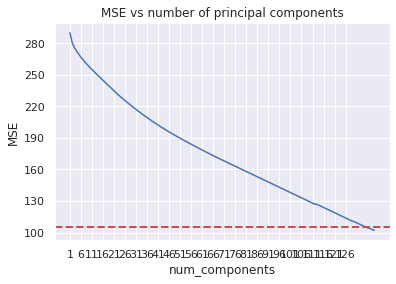

In [0]:
fig, ax = plt.subplots()
ax.plot(loss[:,0], loss[:,1]);
ax.axhline(105, linestyle='--', color='r', linewidth=2);
ax.xaxis.set_ticks(np.arange(1, 130, 5));
ax.yaxis.set_ticks(np.arange(100, 300, 30));
ax.set(xlabel='num_components', ylabel='MSE', title='MSE vs number of principal components');



## 12. Plotting Explained Variance ratio Vs Principal Components

/usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


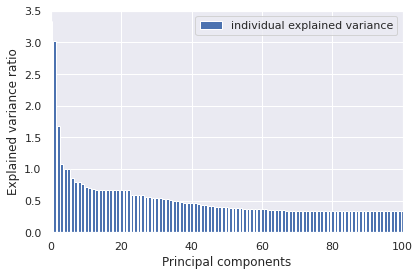

In [0]:
tot = sum(eigvals)
var_exp = [(i / tot)*100 for i in eigvals] # computing variance

plt.figure(figsize=(6, 4))#plotting results

plt.bar(range(len(var_exp)), var_exp, alpha=1 , align='center', label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xlim(0,100)
plt.legend(loc='best')
plt.tight_layout()

In [0]:

# taking random value of M for analysis
print('Eigen values sorted in decreasing order:')
for i in eigvals:
    print(i)
print('Top M (where M=2) Eigenvalues : ', eigvals[:num_components])             # printing top M eigenvalues
print()
print('M eigenvectors correspondong to top M eigenvalues: \n', eigvecs[:,:num_components])  # printing top M eigenvectors corresponding to top M eigenvalues

print()
print('Shape of one eigenvector : ', eigvecs.shape[0]) 

Eigen values sorted in decreasing order:
(120000.26074068056+0j)
(108524.8773126728+0j)
(60281.28187457644+0j)
(38764.42737301027+0j)
(36003.00025002622+0j)
(35997.54296286915+0j)
(30773.44589669053+0j)
(28845.34683142589+0j)
(28380.920218334246+0j)
(27452.289179348434+0j)
(25533.725078548872+0j)
(25062.73888633484+0j)
(24861.969938260954+0j)
(24009.13868496794+0j)
(24002.000166689937+0j)
(24002.000166687005+0j)
(24002.000166684258+0j)
(24002.000166680507+0j)
(24002.000166678572+0j)
(24002.000166677+0j)
(24002.000166667643+0j)
(24002.0001666608+0j)
(23983.12187944142+0j)
(21487.364121562885+0j)
(21257.71709264347+0j)
(21159.027901160345+0j)
(21142.632306478754+0j)
(20321.17963145034+0j)
(19950.75419185917+0j)
(19514.688132465184+0j)
(19478.63964671993+0j)
(19395.5350306128+0j)
(19159.72569259177+0j)
(19051.54539641165+0j)
(18116.52032265435+0j)
(17843.83725395547+0j)
(17720.798734822314+0j)
(17442.261771759782+0j)
(16912.330298886027+0j)
(16772.793841144783+0j)
(16428.363758684787+0j)


## 13. Plotting Eigen Values vs index (decreasing order)

               eigenvalues
0  120000.260741+0.000000j
1  108524.877313+0.000000j
2   60281.281875+0.000000j
3   38764.427373+0.000000j
4   36003.000250+0.000000j


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0.0, 220.0)

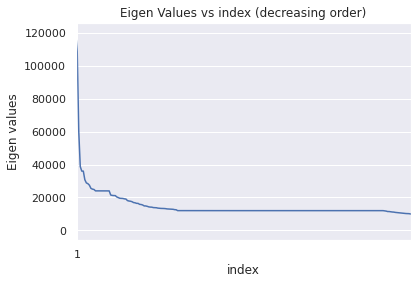

In [0]:
# Plotting sorted eigen values (in decreasing order) v/s its index 
eigvals = np.asarray(eigvals)      # converting to array
eig_df = pd.DataFrame(eigvals)     # making a dataframe with index and eigenvalues
eig_df.rename(columns={0 : 'eigenvalues'},  inplace = True)  #renaming the column of dataframe to eigenvalues
print(eig_df.head())        # printing all the eigenvalues ( 1 to D (total number of features i.e. 4))

fig, ax = plt.subplots()
ax.plot(eigvals);
ax.xaxis.set_ticks(np.arange(1, 5, 5));
ax.set(xlabel='index', ylabel='Eigen values', title='Eigen Values vs index (decreasing order)');
plt.xlim(0,220)




## 14. Plotting Variance on num_components Vs Number of Principal Components

           num_components                    Variance
0      1.000000+0.000000j  1.200003e+05+0.000000e+00j
1      2.000000+0.000000j  2.285251e+05+0.000000e+00j
2      3.000000+0.000000j  2.888064e+05+0.000000e+00j
3      4.000000+0.000000j  3.275708e+05+0.000000e+00j
4      5.000000+0.000000j  3.635738e+05+0.000000e+00j
..                    ...                         ...
134  135.000000+0.000000j  2.351609e+06+0.000000e+00j
135  136.000000+0.000000j  2.363610e+06+0.000000e+00j
136  137.000000+0.000000j  2.375611e+06+0.000000e+00j
137  138.000000+0.000000j  2.387612e+06+0.000000e+00j
138  139.000000+0.000000j  2.399613e+06+0.000000e+00j

[139 rows x 2 columns]


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


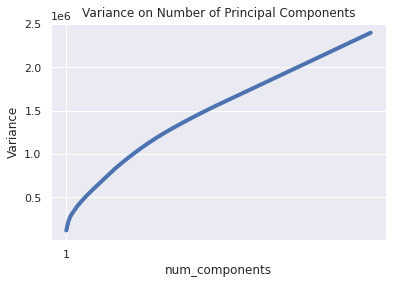

In [0]:
variance_values = np.asarray(variance_values) # converting variance into variance
var_df = pd.DataFrame(variance_values) #convrting variance into a data frame 
var_df.rename(columns={0 : 'num_components', 1: 'Variance'},  inplace = True)  # renaming the column of dataframe to variance
print(var_df.head(150))

sns.set()
fig, ax = plt.subplots()
ax.plot(variance_values[:,0], variance_values[:,1]);
ax.xaxis.set_ticks(np.arange(1, 5, 5));
ax.set(xlabel='num_components', ylabel='Variance', title='Variance on Number of Principal Components');

for l in ax.lines:
    plt.setp(l,linewidth=4)

## 15. Analysis of MSE Error vs No. of principal components with non sorted eigenvalues

In [0]:
def PCA_unsorted(X, num_components):
  Xbar, mu, std = normalize(X) #normalizing our input matrix
  covariance = np.dot(Xbar.T,Xbar) # covariance
  S = covariance # s is covariance
  eigvals, eigvecs = np.linalg.eig(S) # calculating eigen values and eigen vectors
  for i in eigvals:
    print(i)
  sum_value = sum(eigvals[:num_components])#sum of all components, we have NOT TAKEN SORTED LIST
  B = np.stack(eigvecs[:,:num_components]) # calculating matrix B by taking summation of num_components
  P = np.matmul(B,B.T) #P = B * Btranspose
  X_reconstruct = np.matmul(P,X.T) #reconstructing matrix X
  X_reconstruct = X_reconstruct.T
  return X_reconstruct, sum_value 

In [0]:
loss_unsorted = []
reconstructions_unsorted = []
variance_values_unsorted = []

data2 = (features_d [:NUM_DATAPOINTS]) / 255.
#print(data1)
Xbar1, mu1, std1 = normalize(data2)

# iterate over different numbers of principal components, and compute the MSE
for num_component in range(1, 130):
  reconst, sum_value = PCA_unsorted(Xbar1, num_component)  #reconst contains reconstructed Xbar, sum value contains summation of significant of num_component
  error = mse(reconst, Xbar1)
  reconst = reconst*std1 + mu1 #reconst is un-normalized data
  reconstructions_unsorted.append(reconst) # appending un-normalized data
  print('M = {:d}, reconstruction_error = {:f}'.format(num_component, error))
  loss_unsorted.append((num_component, error)) # loss for unsorted un normalized data
  variance_values_unsorted.append((num_component, sum_value)) # variance for unsorted un normalized data

Streaming output truncated to the last 5000 lines.
(24002.000166672115+0j)
(10698.352754348258+0j)
(10835.693260176835+0j)
(10942.204426635222+0j)
(13360.603650486168+0j)
(13352.545849743059+0j)
(13302.7596927251+0j)
(13220.995016641084+0j)
(13057.317916844615+0j)
(12982.960803518114+0j)
(11117.624475961475+0j)
(12901.419566738277+0j)
(12871.446521151754+0j)
(12822.455799677087+0j)
(11179.550928091794+0j)
(12603.882971597744+0j)
(12538.56356033873+0j)
(11319.1172150455+0j)
(11462.57481064165+0j)
(11454.801572293743+0j)
(11727.211850862288+0j)
(11862.728402596229+0j)
(12016.113052478828+0j)
(12013.720936279979+0j)
(12008.078340766475+0j)
(12007.229121486629+0j)
(12006.58885578679+0j)
(12005.799086039355+0j)
(12005.175342817618+0j)
(12004.88082851038+0j)
(12004.633708489555+0j)
(12004.431245373218+0j)
(12003.925413427703+0j)
(12003.802026040508+0j)
(12003.739683784013+0j)
(12003.606287984661+0j)
(12003.316453460951+0j)
(12002.626798269048+0j)
(12002.967568284335+0j)
(12002.854240978953+0

## Plotting MSE vs No. of Principal components(Unsorted)

           num_components                   MSE
0      1.000000+0.000000j  289.999978+0.000000j
1      2.000000+0.000000j  280.956238+0.000000j
2      3.000000+0.000000j  275.932798+0.000000j
3      4.000000+0.000000j  272.702429+0.000000j
4      5.000000+0.000000j  269.702634+0.000000j
..                    ...                   ...
124  125.000000+0.000000j  151.281667+0.000000j
125  126.000000+0.000000j  150.179917+0.000000j
126  127.000000+0.000000j  149.091807+0.000000j
127  128.000000+0.000000j  148.009894+0.000000j
128  129.000000+0.000000j  147.083425+0.000000j

[129 rows x 2 columns]


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


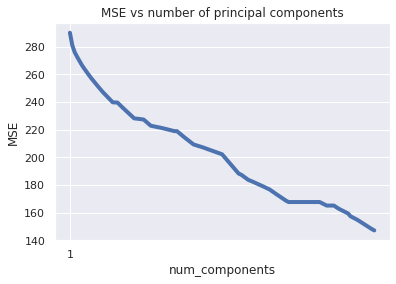

In [0]:
loss_unsorted = np.asarray(loss_unsorted) # loss unsorted as an array
loss_df = pd.DataFrame(loss_unsorted) # as an dataframe
loss_df.rename(columns={0 : 'num_components', 1: 'MSE'},  inplace = True)  #renaming the column of dataframe to MSE
print(loss_df)

fig, ax = plt.subplots()
ax.plot(loss_unsorted[:,0], loss_unsorted[:,1]);
ax.xaxis.set_ticks(np.arange(1, 5, 5));
ax.set(xlabel='num_components', ylabel='MSE', title='MSE vs no. of principal components(Unsorted)');

for l in ax.lines:
    plt.setp(l,linewidth=4)